In [15]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

import matplotlib.pyplot as plt

In [16]:
#read in the transcripts
gene_names = []
transcripts = []
name_to_transcript = {}
with open("Mus_musculus.GRCm38.cdna.all.fa") as f_transcript:
    cur_transcript = ""
    for line in f_transcript:
        if(line[0] == ">"):
            gene_name = line[1:]
            gene_name_arr = gene_name.split()
            gene_name = gene_name_arr[0]
            gene_names.append(gene_name)
            if(cur_transcript != ""):
                #name_to_transcript[gene_name] = transcript
                transcripts.append(cur_transcript)
                cur_transcript = ""
        else:
            cur_transcript = cur_transcript + line[:-1]
transcripts.append(cur_transcript)
for i in range(len(gene_names)):
    name_to_transcript[gene_names[i]] = transcripts[i]
for i in name_to_transcript:
    print(i)
    print(name_to_transcript[i])
    break
print(name_to_transcript['ENSMUST00000196221.1'])

ENSMUST00000196221.1
ATGGCATAT
ATGGCATAT


In [17]:
def get_gene_info(info):
    if(info == ""):
        return ""
    info_arr = info.split()
    gene_info = info_arr[0]
    if(gene_info[0] == ">"):
        return gene_info[1:]
    else:
        first_slash = gene_info.find('/')
    return gene_info[first_slash + 1:]	

In [18]:
def get_read(f_reads, seek):
    #get info, location, and read
    gene_info = ""
    info = ""
    init_loc = 0
    end_loc = 0
    read = ""
    if(seek == -1):
        seek = f_reads.seek(0,1)
    else:
        seek = f_reads.seek(seek,0)
    info_line = f_reads.readline()
    if(info_line == ""):
        return ""
    #break this into the mates location and everythin
    info_arr = info_line.split("mate")
    #print(info_arr[1])
    first_colon = info_arr[1].find(':')
    location = info_arr[1][first_colon + 1:-1]
    location_arr = location.split('-')
    init_loc = int(location_arr[0])
    end_loc = int(location_arr[1])
    
    f_reads.seek(0,1)
    read = f_reads.readline()

    gene_info = get_gene_info(info_arr[0][1:])

    return (gene_info, init_loc, end_loc, read, seek)

In [19]:
def get_alignment_score(read, transcript_segment):
    alignments = pairwise2.align.localxx(read, transcript_segment)
    scores = []
    for a in alignments:
        al1, al2, score, begin, end = a
        scores = scores + [score]
        #print(format_alignment(*a))
        break
    score = max(scores)
    #print(score)
    return score

In [20]:
def print_transcript_dist(transcript_dist, gene_name):
    axes = plt.gca()
    axes.set_ylim([0, max(transcript_dist) + 1])
    plt.plot(transcript_dist)
    plt.ylabel("read coverage")
    plt.xlabel("transcript location")
    plt.title(gene_name)
    plt.show()
    return

In [21]:
def get_info(line):
    line_arr = line.split()
    transcript_name = line_arr[0].split('/')[1]
    loc = line_arr[11]
    loc_arr = loc.split('mate')[1][2:-1].split('-')
    init_loc = loc_arr[0]
    end_loc = loc_arr[1]
    return (transcript_name, int(init_loc), int(end_loc))

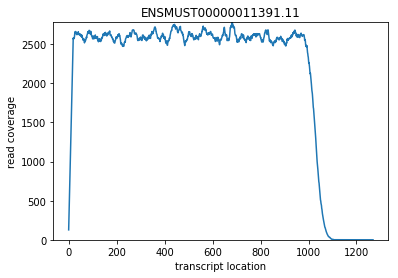

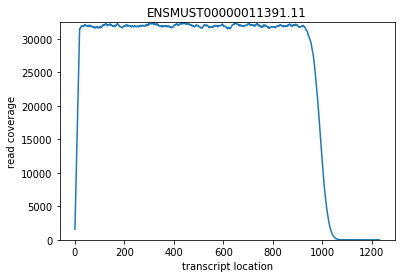

In [27]:
f_scores = open("simulated_scores", "w+")
cur_transcript_name = ""
count = 0
read = ""
transcript_dist = []

with open("simulated_mice_2gene2cell/sample_01.fasta") as f_simulated_reads:
    for line in f_simulated_reads:
        if(line[0] == '>'):
            #add the last transcript to the scores and the distribution plot
            (transcript_name, init_loc, end_loc) = get_info(line)
            if(cur_transcript_name != transcript_name):
                cur_transcript_name = transcript_name
                #print(cur_transcript_name)
                f_scores.write(cur_transcript_name)
                transcript = name_to_transcript[cur_transcript_name]
                if(len(transcript_dist) > 0):
                    print_transcript_dist(transcript_dist, cur_transcript_name)
                transcript_dist = []
                for i in range(len(transcript)):
                    transcript_dist.append(0)
        else:
            #compare read
            read = line[:-1]
            transcript_read = transcript[init_loc - 1: end_loc]
       
            alignments = pairwise2.align.localxx(read, transcript_read)
            max_a = alignments[0]
            max_score = 0
            for a in alignments:
                al1, al2, score, begin, end = a
                if(score > max_score):
                    max_score = score
                    max_a = a
            al1, al2, score, begin, end = max_a
            #print(score)
            f_scores.write(str(score))
            
            transcript_dist_fragment = transcript_dist[init_loc - 1: end_loc]
            transcript_dist_fragment = [x+1 for x in transcript_dist_fragment]
            transcript_dist = transcript_dist[:init_loc - 1] + transcript_dist_fragment + transcript_dist[end_loc:]


if(len(transcript_dist) > 0):
    print_transcript_dist(transcript_dist, cur_transcript_name)

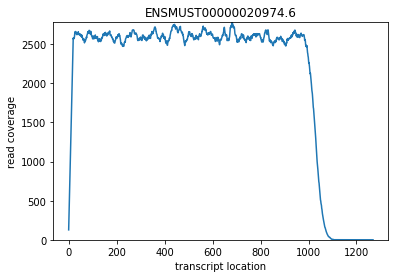

ENSMUST00000011391.11
TATCACCAAATATACCATAT
CCTAATCTGCTTTGCGGCGC
880
899


IndexError: string index out of range

In [12]:
f_scores = open("simulated_scores", "w+")
cur_transcript_name = ""
count = 0
read = ""
name_to_scores = {}

#make a transcript distribution for the current transcript
cur_transcript = ""
transcript_dist = []

with open("simulated_mice_2gene2cell/sample_01.fasta") as f_simulated_reads:
    line = f_simulated_reads.readline()
    while(line):
        if(len(line) == 0):
            print(cur_transcript)
            print(read)
            print(transcript_read)
        elif(line[0] == ">"):
            info = get_info(line)
            (transcript_name, init_loc, end_loc) = info
            if(cur_transcript != "" and transcript_name != cur_transcript):
                print_transcript_dist(transcript_dist, cur_transcript)
                transcript_dist = []
            cur_transcript = transcript_name
            f_scores.write(cur_transcript)
            if(not(transcript_name in name_to_scores)):
                name_to_scores[transcript_name] = []
            #get the entire read
            read = ""
            line = " "
            while(True):
                line = f_simulated_reads.readline()
                if(len(line) == 0):
                    print(cur_transcript)
                    print(read)
                    print(transcript_read)
                    print(init_loc)
                    print(end_loc)
                if(line[0] == ">"):
                    break
                read = read + line[:-1]
                
            transcript = name_to_transcript[transcript_name]
            transcript_read = transcript[init_loc - 1: end_loc]
       
            alignments = pairwise2.align.localxx(read, transcript_read)
            max_a = alignments[0]
            max_score = 0
            for a in alignments:
                al1, al2, score, begin, end = a
                if(score > max_score):
                    max_score = score
                    max_a = a
            al1, al2, score, begin, end = max_a
            #print(format_alignment(al1, al2, score, begin, end))
            f_scores.write(str(max_score))
            
            if(len(transcript_dist) == 0):
                for i in range(len(transcript)):
                    transcript_dist.append(0)
            transcript_dist_fragment = transcript_dist[init_loc - 1: end_loc]
            transcript_dist_fragment = [x+1 for x in transcript_dist_fragment]
            transcript_dist = transcript_dist[:init_loc - 1] + transcript_dist_fragment + transcript_dist[end_loc:]

            count = count + 1

if(len(transcript_dist) > 0):
    print_transcript_dist(transcript_dist, cur_transcript)